# **Computer Vision** | MSc in Data Science and Engineering
## Assignment 2 - CAPTCHA Decoding
### Bruno Silva (up201508756) **|** João Carvalho (up201507023)
##### November, 2024


## Introduction


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms.functional as func
import torch.optim as optim
import os
import cv2 as cv

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


## Data

In [2]:
"8p65.png".split('.')[0]

'8p65'

In [2]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform):

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # getting all image paths and labels
        for img_name in os.listdir(root_dir):
            img_path = os.path.join(root_dir, img_name)

            self.image_paths.append(img_path)

            label = img_name.split('.')[0] # removing the .png from the name
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths) # to get the len(dataset)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # labels should be a list of characters
        label = list(label)
        return image, label


In [3]:
char_map = {ch: idx for idx, ch in enumerate("0123456789abcdefghijklmnopqrstuvwxyz")}
char_map["<PAD>"] = len(char_map)  # images are 4 or 5 characters long. PyTorch requires the labels to be of the same lenght
idx_to_char = {idx: ch for ch, idx in char_map.items()}  # Reverse mapping

char_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35,
 '<PAD>': 36}

In [4]:
# This function will deal with the label padding when applying the transform

def collate_fn(batch):

    images = []
    labels = []
    label_lengths = []

    for image, label in batch:
        images.append(image)
        # label to indices
        label_indices = torch.tensor([char_map[ch] for ch in label], dtype=torch.long)
        labels.append(label_indices)
        label_lengths.append(len(label_indices))

    # tensor (batch_size, 3, H, W)
    images = torch.stack(images)

    # padding the labels
    labels = pad_sequence(labels, batch_first=True, padding_value=char_map["<PAD>"])

    return images, labels, torch.tensor(label_lengths, dtype=torch.long)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_dir = 'CAPTCHA_dataset/soft/train'
test_dir = 'CAPTCHA_dataset/soft/test'

train_dataset = CaptchaDataset(root_dir=train_dir, transform=transform)
test_dataset = CaptchaDataset(root_dir=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

Image Batch Shape: torch.Size([32, 3, 100, 200])
Labels Shape: torch.Size([32, 5])
Label Lengths: tensor([5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 5, 4, 5, 4, 5, 5, 5, 4, 5, 4, 5, 4, 5,
        5, 4, 4, 5, 4, 4, 4, 4])


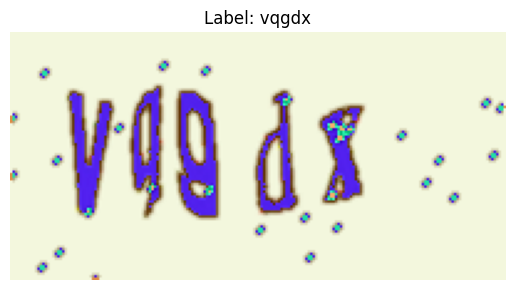

In [7]:
for images, labels, label_lengths in train_loader:
    print("Image Batch Shape:", images.shape)
    print("Labels Shape:", labels.shape)
    print("Label Lengths:", label_lengths)

    # first image in the batch
    first_image = images[0]
    label = labels[0]
    label_length = label_lengths[0]

    #converting label indices back to characters
    decoded_label = ''.join([idx_to_char[idx.item()] for idx in label[:label_length]])

    # this is for matplotlib to display
    first_image = func.to_pil_image(first_image)

    plt.imshow(first_image)
    plt.title(f"Label: {decoded_label}")
    plt.axis('off')
    plt.show()

    break

## Pre-processing

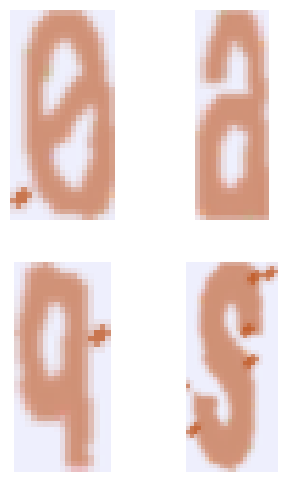

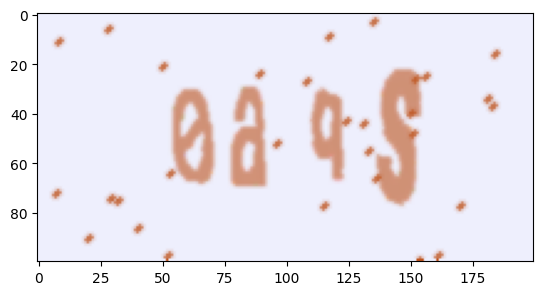

In [ ]:
train_data_folder = "CAPTCHA_dataset/soft/train"

# for img in os.listdir(train_data_folder):

image_path = os.path.join(train_data_folder, "0aqs.png")
image = cv.imread(image_path)

gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# adaptive thresholding
_, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# to get rid of very small contours
threshold = 50
contours = [contour for contour in contours if cv.contourArea(contour) > threshold]

# draw contours
image2 = image.copy()

# draw contours
# cv.drawContours(image2, contours, -1, (0, 255, 0), 2)

# draw bounding boxes
# for contour in contours:
#     x, y, w, h = cv.boundingRect(contour)
#     cv.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 1)

# create individual images based on bounding boxes
individual_images = []
x_values = []
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    x_values.append(x)
    individual_image = image[y:y+h, x:x+w]
    individual_images.append(individual_image)

# get the sorted idx of x_values -> this is to order the images from left to right, otherwise the contours are ordered in some other way
sorted_idx = np.argsort(x_values) 
# sort individual_images based on sorted_idx
individual_images = [individual_images[i] for i in sorted_idx]


# for i in range(len(individual_images)):
#     cv.imwrite(f"individual_images/image_{i}.png", individual_images[i])

plt.figure(figsize=(4,6), dpi=100)
plt.subplot(2,2,1)
plt.imshow(individual_images[0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(individual_images[1])
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(individual_images[2])
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(individual_images[3])
plt.axis('off')
plt.show()

plt.imshow(image)

# x, y, w, h = cv.boundingRect(all_contours)
# cv.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 2)

## Baseline

In [ ]:
class CNN_baseline(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(3, 16, 3) # colored image, 16 3x3 kernels
    self.fc = nn.Linear(16 * 198 * 98, 36) # after the convolutional layer, the 200x100 image will be 198x98. output is 36 characters

  def forward(self, x):
    x = F.relu(self.conv(x))
    x = torch.flatten(x, 1)
    x = self.fc(x)

In [ ]:
model = CNN_baseline().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

Treino:
- Separar todas as imagens em caracteres diferentes e guardar com a respetiva label (temos de ter a ordem porque os caracteres estão por ordem no nome). Basicamente criar um dataset novo. Treinar o modelo nestes caracteres individuais.

Teste:
- A pipeline vai começar por dividir a imagem em caracteres e guarda a ordem. Depois caracter a caracter aplica o modelo para saber que caracter se trata.
- O output são as predictions de cada caracter por ordem.